In [1]:

import glob
import os
import shutil

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from pipeline.python.utils import convert_range


from pipeline.python.utils import natural_keys, label_figure
import traceback
from pipeline.python.retinotopy import utils as rutils
import json
import tifffile as tf
from scipy import ndimage



/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors
import cPickle as pkl
import h5py

In [3]:
%matplotlib notebook

In [4]:
import matplotlib.ticker as ticker

def format_ticks(x):
    return '%.1f' % round(x, 2)

# set output dir

In [5]:
outdir = os.path.join('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'figures', 'caiman-examples')
if not os.path.exists(outdir):
    os.makedirs(outdir)


# Select dataset

In [6]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC085'
session = '20190626'
fov = 'FOV1_zoom1p0x'
retinorun = 'retino_run1'
data_identifier = '|'.join([animalid, session, fov, retinorun])


# Select colormap

In [7]:
# Load colormap
colormap = 'colorwheel'
cmapdir = '/n/coxfs01/julianarhee/aggregate-visual-areas/colormaps'
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])

    

# Get screen info

In [8]:

# adjust elevation limit to show only monitor extent
screeninfo_fpath = glob.glob(os.path.join(rootdir, animalid, 'epi_maps', '*.json'))[0]
with open(screeninfo_fpath, 'r') as f:
    screen = json.load(f)

screen_width = screen['screen_params']['screen_size_x_degrees']
screen_height = screen['screen_params']['screen_size_t_degrees']

screen_left = -1*screen_width/2.
screen_right = screen_width/2.
screen_top = screen_height/2.
screen_bottom = -1*screen_height/2.
    
elev_cutoff = screen_top / screen_right
print("[AZ]: screen bounds: (%.2f, %.2f)" % (screen_left, screen_right))
print("[EL]: screen bounds: (%.2f, %.2f)" % (screen_top, screen_bottom))


[AZ]: screen bounds: (-58.78, 58.78)
[EL]: screen bounds: (33.66, -33.66)


In [9]:
screen_x = 119.5564
screen_y = 67.323
resolution = [1024, 768]


# Legends

In [10]:
deg_per_pixel = screen_x / float(resolution[0])


In [11]:
x = np.linspace(0, 2*np.pi, int(round(screen_x)))
y = np.linspace(0, 2*np.pi, int(round(screen_y)) )

xv, yv = np.meshgrid(x, y)


az_legend = (2*np.pi) - xv
el_legend = yv


In [12]:
# def convert_boundary(boundary_pix, center_deg ,deg_per_pixel):

#     boundary_deg = boundary_pix * deg_per_pixel
#     boundary_relative_deg = boundary_deg - center_deg
    
#     return boundary_relative_deg

In [13]:
az_screen = convert_range(az_legend, newmin=0, newmax=screen_x, oldmin=0, oldmax=2*np.pi)
el_screen = convert_range(el_legend, newmin=0, newmax=screen_x, oldmin=0, oldmax=2*np.pi)


In [14]:
az_screen.shape

(67, 120)

In [15]:
fig, ax = pl.subplots()
im = ax.imshow(az_screen, cmap=cmap_phase)
#ax.invert_xaxis()
pl.colorbar(im)
ax.set_xticks(np.linspace(0, int(round(screen_x)), 5))
ax.set_xticklabels([int(round(i)) for i in np.linspace(0, int(round(screen_x)), 5)][::-1])

spos1, epos1 = pos1_deg[0], pos1_deg[-1]
spos2, epos2 = pos2_deg[0], pos2_deg[-1]

ax.axvline(x=screen_x-spos1, c='w')
ax.axvline(x=screen_x-epos1, c='w')

ax.axvline(x=screen_x-spos2, c='w')
ax.axvline(x=screen_x-epos2, c='w')

ax.set_yticks([])
ax.set_yticklabels([])
ax.tick_params(axis='x', length=0)
ax.set_frame_on(False)
#ax.set_xlim(ax.get_xlim()[::-1])


figname = 'cond2-grouped-dff-binned-pos_%s_%s_LEGEND' % (cmap, skey)

pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname

<IPython.core.display.Javascript object>

NameError: name 'pos1_deg' is not defined

# Mapping

In [16]:
def smooth_phase_nans(inputArray, sigma, sz):
    
    V=inputArray.copy()
    V[np.isnan(inputArray)]=0
    VV=smooth_phase_array(V,sigma,sz)

    W=0*inputArray.copy()+1
    W[np.isnan(inputArray)]=0
    WW=smooth_phase_array(W,sigma,sz)

    Z=VV/WW

    return Z

In [17]:

def smooth_array(inputArray, fwhm, phaseArray=False):
    szList=np.array([None,None,None,11,None,21,None,27,None,31,None,37,None,43,None,49,None,53,None,59,None,55,None,69,None,79,None,89,None,99])
    sigmaList=np.array([None,None,None,.9,None,1.7,None,2.6,None,3.4,None,4.3,None,5.1,None,6.4,None,6.8,None,7.6,None,8.5,None,9.4,None,10.3,None,11.2,None,12])
    sigma=sigmaList[fwhm]
    sz=szList[fwhm]
    #print(sigma, sz)
    if phaseArray:
        if np.isnan(inputArray).any():
            print("... phase, found nans")
            outputArray = smooth_phase_nans(inputArray, sigma, sz)
        else:
            outputArray = smooth_phase_array(inputArray,sigma,sz)
    else:
        outputArray=cv2.GaussianBlur(inputArray, (sz,sz), sigma, sigma)
        
    return outputArray
        
def smooth_phase_array(theta,sigma,sz):
    #build 2D Gaussian Kernel
    kernelX = cv2.getGaussianKernel(sz, sigma); 
    kernelY = cv2.getGaussianKernel(sz, sigma); 
    kernelXY = kernelX * kernelY.transpose(); 
    kernelXY_norm=np.true_divide(kernelXY,np.max(kernelXY.flatten()))
    
    #get x and y components of unit-length vector
    componentX=np.cos(theta)
    componentY=np.sin(theta)
    
    #convolce
    componentX_smooth=signal.convolve2d(componentX,kernelXY_norm,mode='same',boundary='symm')
    componentY_smooth=signal.convolve2d(componentY,kernelXY_norm,mode='same',boundary='symm')

    theta_smooth=np.arctan2(componentY_smooth,componentX_smooth)
    return theta_smooth


In [18]:


def get_maps(mapdata, smooth_fwhm=None, mag_thr=None, recenter=True):
    phase_az = mapdata['phaseMap'].copy()
    mag_az = mapdata['magRatioMap'].copy()

    if smooth_fwhm is not None:
        phase_az =smooth_array(phase_az, smooth_fwhm, phaseArray=True)
        mag_az = smooth_array(mag_az, smooth_fwhm)

    if recenter:
        phaseC_az=np.copy(phase_az)
        phaseC_az[phase_az<0]=-phase_az[phase_az<0]
        phaseC_az[phase_az>0]=(2*np.pi)-phase_az[phase_az>0]
        phasemin = 0
        phasemax = 2*np.pi
    else:
        phaseC_az = np.copy(phase_az)
        phasemin = -np.pi
        phasemax = np.pi


    phaseC_az[mag_az<mag_thr]=np.nan
    
    return phaseC_az, mag_az, phasemin, phasemax



# Load data

In [20]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC085' #'JC091'
session2p = '20190626' #'20190623'
fov = 'FOV1_zoom1p0x'
retinorun = 'retino_run1'

avgtraces_path = glob.glob(os.path.join(rootdir, animalid, session2p, fov, retinorun, 'retino_analysis', 
                                  'analysis*', 'traces', 'averaged_roi_traces.pkl'))[0]
retinodir = avgtraces_path.split('/traces/')[0]
print(retinodir)

/n/coxfs01/2p-data/JC085/20190626/FOV1_zoom1p0x/retino_run1/retino_analysis/analysis002_a7c3d2


In [21]:
with open(avgtraces_path, 'rb') as f:
    avgtraces = pkl.load(f)

In [22]:
avgtraces.keys()

['source_tifs', 'traces', 'RETINOID', 'masks', 'mwinfo', 'conditions']

In [23]:
trials_by_cond = avgtraces['conditions']
trials_by_cond

{u'bottom': [11, 13, 14, 3],
 u'left': [15, 16, 2, 7],
 u'right': [12, 5, 4, 6],
 u'top': [10, 1, 9, 8]}

# Load raw

In [24]:
retino_dpath = os.path.join(os.path.split(avgtraces_path)[0], 'extracted_traces.h5')
tfile = h5py.File(retino_dpath, 'r')
tfile.keys()

[u'File001',
 u'File002',
 u'File003',
 u'File004',
 u'File005',
 u'File006',
 u'File007',
 u'File008',
 u'File009',
 u'File010',
 u'File011',
 u'File012',
 u'File013',
 u'File014',
 u'File015',
 u'File016']

# Visualize 1 condition 

In [25]:
currcond = 'right'

In [26]:
stiminfo = avgtraces['traces'][currcond]['info']
stiminfo

{'frame_rate': 44.6528, 'n_reps': 4, 'stimfreq': 0.24, 'stimulus': u'right'}

In [27]:
fr = float(stiminfo['frame_rate'])
n_frames = int(avgtraces['traces'][currcond]['traces'].shape[-1])
stimfreq = float(stiminfo['stimfreq'])
stimperiod = 1./stimfreq

n_cycles = int(round((n_frames/fr) / stimperiod))
n_frames_per_cycle = int(np.floor(stimperiod * fr))

cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

In [28]:
cycle_starts

array([   0,  186,  372,  558,  744,  930, 1116, 1302, 1488, 1674, 1860,
       2046])

#### average traces

In [29]:
xticks = np.linspace(0, n_frames, 5)
xticklabels = [round(float(f)/fr) for f in xticks]


In [30]:
rois_plot = [57, 175, 247]
colors = ['royalblue', 'darkorange', 'forestgreen']

<IPython.core.display.Javascript object>


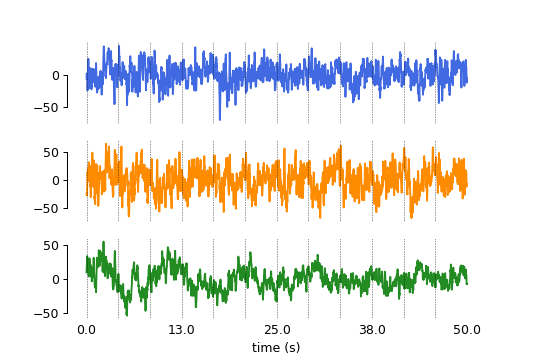

Text(0.5,0,u'time (s)')

In [31]:
fig, axes = pl.subplots(3, 1, figsize=(6,4), sharex=True, sharey=False)
for ri, (ax, roi) in enumerate(zip(axes, rois_plot)):
    meanval = avgtraces['traces']['right']['traces'][roi, :].mean()
    ax.plot( (avgtraces['traces']['right']['traces'][roi, :]-meanval) / meanval , color=colors[ri])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    sns.despine(ax=ax, trim=True, bottom=True)
    for cyc in cycle_starts:
        ax.axvline(x=cyc, linestyle=':', color='k', lw=0.5)
    ax.tick_params(which='both', axis='x', length=0)
        
ax.set_xlabel('time (s)')

#figname = 'example-traces_cond-%s_%s' % (currcond, skey)
#pl.savefig(os.path.join(outdir, '%s.png' % figname))
#print figname

# Get retino run info

In [32]:
def block_mean(ar, fact):
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy/fact * (X/fact) + Y/fact
    res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    res.shape = (sx/fact, sy/fact)
    return res

def block_mean_stack(stack0, ds_factor, along_axis=2):
    if along_axis==2:
        im0 = block_mean(stack0[:,:,0],ds_factor) 
        print im0.shape
        stack1 = np.zeros((im0.shape[0],im0.shape[1],stack0.shape[2]))
        for i in range(0,stack0.shape[2]):
            stack1[:,:,i] = block_mean(stack0[:,:,i],ds_factor) 
    else:
        # This is for downsampling masks:
        im0 = block_mean(stack0[0,:,:],ds_factor) 
        print "... block mean on MASKS by %i (target: %s)" % (ds_factor, str(im0.shape))

        stack1 = np.zeros((stack0.shape[0], im0.shape[0], im0.shape[1]))
        for i in range(stack0.shape[0]):
            stack1[i,:,:] = block_mean(stack0[i,:,:],ds_factor) 

    return stack1

In [33]:
retinodir

'/n/coxfs01/2p-data/JC085/20190626/FOV1_zoom1p0x/retino_run1/retino_analysis/analysis002_a7c3d2'

In [34]:
retinoid = os.path.split(retinodir)[-1].split('_')[0]
print(retinoid)

analysis002


In [35]:
retinoid, retinoinfo = rutils.load_retino_analysis_info(animalid, session, fov, retinorun, \
                                 retinoid, use_pixels=False, rootdir=rootdir)


FOV: FOV1_zoom1p0x, run: retino_run1


In [36]:
retinoinfo

{u'DST': u'/n/coxfs01/2p-data/JC085/20190626/FOV1_zoom1p0x/retino_run1/retino_analysis/analysis002_a7c3d2',
 u'PARAMS': {u'average_frames': u'5',
  u'downsample_factor': u'2',
  u'excluded_tiffs': [],
  u'hashid': u'b7c710',
  u'minus_rolling_mean': True,
  u'rid_hash': u'4b8549',
  u'roi_id': u'rois001',
  u'roi_type': u'manual2D_circle',
  u'signal_channel': 1,
  u'smooth_fwhm': None,
  u'tiff_source': u'/n/coxfs01/2p-data/JC085/20190626/FOV1_zoom1p0x/retino_run1/processed/processed001_105369/mcorrected_56f091'},
 u'SRC': u'/n/coxfs01/2p-data/JC085/20190626/FOV1_zoom1p0x/retino_run1/processed/processed001_105369/mcorrected_56f091',
 u'analysis_hash': u'a7c3d2',
 u'analysis_id': u'analysis002'}

In [37]:
roiid = retinoinfo['PARAMS']['roi_id']
# Load reference image
imgs = glob.glob(os.path.join(rootdir, animalid, session, fov, retinorun, 'processed',\
                      'processed001*', 'mcorrected_*', 'std_images.tif'))[0]
zimg = tf.imread(imgs)
zimg = zimg.mean(axis=0)


if retinoinfo['PARAMS']['downsample_factor'] is not None:
    zimg = block_mean(zimg, int(retinoinfo['PARAMS']['downsample_factor']))

d1, d2 = zimg.shape



<IPython.core.display.Javascript object>


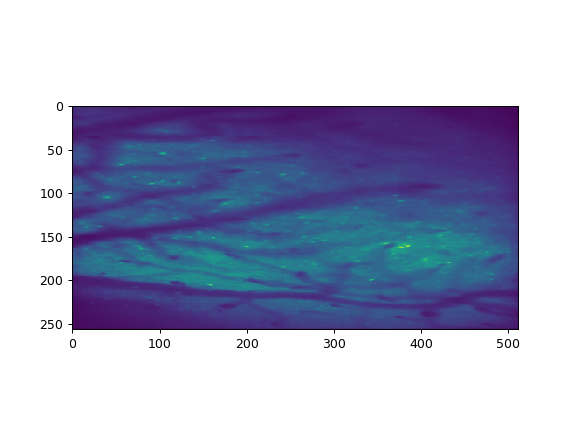

In [38]:
pl.figure()
pl.imshow(zimg)

# Reprocess with raw traces

In [39]:
trials_by_cond

{u'bottom': [11, 13, 14, 3],
 u'left': [15, 16, 2, 7],
 u'right': [12, 5, 4, 6],
 u'top': [10, 1, 9, 8]}

In [40]:
currcond = 'right'

# Process raw traces

In [41]:

def do_fft_analysis(avg_traces, idx, n_frames):
    fft_results = np.fft.fft(avg_traces, axis=0) #avg_traces.apply(np.fft.fft, axis=1)

    # get phase and magnitude
    mag_data = abs(fft_results)
    phase_data = np.angle(fft_results)

    # sort mag and phase by freq idx:
    mag_data = mag_data[idx]
    phase_data = phase_data[idx]

    # exclude DC offset from data
    mag_data = mag_data[int(np.round(n_frames/2.))+1:, :]
    phase_data = phase_data[int(np.round(n_frames/2.))+1:, :]

    #unpack values from frequency analysis
    mag_array = mag_data[freq_idx, :]
    phase_array = phase_data[freq_idx, :]

    #get magnitude ratio
    tmp = np.copy(mag_data)
    #tmp = np.delete(tmp,freq_idx,0)
    nontarget_mag_array=np.sum(tmp,0)
    magratio_array=mag_array/nontarget_mag_array

    return magratio_array, phase_array


In [42]:
# label frequency bins
freqs = np.fft.fftfreq(n_frames, float(1/fr))
idx = np.argsort(freqs)
freqs=freqs[idx]
print(freqs)

# exclude DC offset from data
freqs=freqs[int(np.round(n_frames/2.))+1:]

# Identify freq idx:
freq_idx=np.argmin(np.absolute(freqs-stimfreq))#find out index of stimulation freq
top_freq_idx=np.where(freqs>1)[0][0]#find out index of 1Hz, to cut-off zoomed out plot
print("Target freq: %.3f Hz" % freqs[freq_idx])
#max_mod_idx=np.argmax(magnitudes[freq_idx, :],0)#best pixel index


[-22.31640161 -22.29640484 -22.27640806 ...  22.27640806  22.29640484
  22.31640161]
Target freq: 0.240 Hz


In [43]:
import pandas as pd

def subtract_rolling_mean(trace, windowsz):
    #print(trace.shape)
    tmp1 = np.concatenate((np.ones(windowsz)*trace.values[0], trace, np.ones(windowsz)*trace.values[-1]),0)
    rolling_mean = np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    rolling_mean=rolling_mean[windowsz:-windowsz]
    return np.subtract(trace, rolling_mean)

def detrend_array(roi_trace, frame_rate=44.65, stimfreq=0.24):
    #print('Removing rolling mean from traces...')
    windowsz = int(np.ceil((np.true_divide(1,stimfreq)*3)*frame_rate))
    detrend_roi_trace = roi_trace.apply(subtract_rolling_mean, args=(windowsz,), axis=0)
    return detrend_roi_trace #pd.DataFrame(detrend_roi_trace)
        
def temporal_downsample(trace, windowsz):
    tmp1=np.concatenate((np.ones(windowsz)*trace.values[0], trace, np.ones(windowsz)*trace.values[-1]),0)
    tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    tmp2=tmp2[windowsz:-windowsz]
    return tmp2

        
def downsample_array(roi_trace, temporal_ds=5):
    print('Performing temporal smoothing on traces...')
    windowsz = int(temporal_ds)
    smooth_roi_trace = roi_trace.apply(temporal_downsample, args=(windowsz,), axis=0)
    return smooth_roi_trace
    
# def process_array(roi_trace, detrend=True, temporal_ds=None, frame_rate=44.65, stimfreq=0.24):
    
#     #frame_rate = stack_info['frame_rate']
#     #stimfreq = stack_info['stimfreq']
#     #hard-code for now, in the future, get from mworks file
#     if detrend:
#         print('Removing rolling mean from traces...')
#         detrend_roi_trace = np.zeros(roi_trace.shape)

#         windowsz = int(np.ceil((np.true_divide(1,stimfreq)*3)*frame_rate))

#         for roi in range(roi_trace.shape[0]):
#             tmp0=roi_trace[roi,:];
#             tmp1=np.concatenate((np.ones(windowsz)*tmp0[0], tmp0, np.ones(windowsz)*tmp0[-1]),0)

#             rolling_mean=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
#             rolling_mean=rolling_mean[windowsz:-windowsz]

#             detrend_roi_trace[roi,:]=np.subtract(tmp0,rolling_mean)
#         roi_trace = detrend_roi_trace
#         del detrend_roi_trace

#     if temporal_ds is not None:
#         print('Performing temporal smoothing on traces...')
#         smooth_roi_trace = np.zeros(roi_trace.shape)

#         windowsz = int(temporal_ds)

#         for roi in range(roi_trace.shape[0]):
#             tmp0=roi_trace[roi,:];
#             tmp1=np.concatenate((np.ones(windowsz)*tmp0[0], tmp0, np.ones(windowsz)*tmp0[-1]),0)

#             tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
#             tmp2=tmp2[windowsz:-windowsz]

#             smooth_roi_trace[roi,:]=tmp2
#         roi_trace = smooth_roi_trace
#         del smooth_roi_trace

#     return roi_trace



In [44]:
def average_tifs(tifpaths):
    for ti, tfn in tifpaths:
        stack = tf.imread(tfn)
        if ti > 0:
            stack += stack
    return stack / float(len(tifpaths))
    

In [45]:

def load_retino_trials(retino_dpath, trials_by_cond, temporal_ds=None):
    traces = {}
    try:
        tfile = h5py.File(retino_dpath, 'r')
        for condition, trialnums in trials_by_cond.items():
            print("Cond: %s" % condition)
            dlist = tuple([process_data(tfile, trialnum, temporal_ds=None) for trialnum in trialnums])
            dfcat = pd.concat(dlist)
            df_rowix = dfcat.groupby(dfcat.index)
            meandf = df_rowix.mean()
            if temporal_ds is not None:
                meandf = downsample_array(meandf, temporal_ds=temporal_ds)
            traces[condition] = meandf
    except Exception as e:
        traceback.print_exc()
    finally:
        tfile.close()
        
    return traces

In [46]:
def process_data(tfile, trialnum, temporal_ds=None, add_offset=True):
    print(tfile['File001'].keys())
    ldata = pd.DataFrame(tfile['File%03d' % int(trialnum)][trace_type][:].T)
    xd = detrend_array(ldata, frame_rate=fr, stimfreq=stimfreq)
    f0 = ldata.subtract(xd).mean().mean()
    if trace_type in ['corrected', 'dff'] and add_offset:
        #print("adding NP offset")
        neuropil = pd.DataFrame(tfile['File%03d' % int(trialnum)]['neuropil'][:].T)
        neuropil_xd = detrend_array(neuropil, frame_rate=fr, stimfreq=stimfreq)
        neuropil_offset = neuropil_xd.mean(axis=0)
        xdata = xd + f0 + neuropil_offset
        del neuropil_xd
        del neuropil
    else:
        xdata = xd + f0
    del ldata
    
    if temporal_ds is not None:
        xdata = downsample_array(xdata, temporal_ds=temporal_ds)
        
    return xdata

In [47]:
# processid = 'processed001'
# tifpaths = sorted(glob.glob(os.path.join(rootdir, animalid, session, fov, retinorun, 'processed', 
#                   '%s*' % processid, 'mcorrected_*', '*Channel01*.tif')), key=natural_keys)
# print len(tifpaths)

# srcdir = os.path.split(tifpaths[0])[0]
# print(srcdir)

# Set TRACE TYPE

In [48]:
trace_type = 'neuropil'
add_offset = True

In [49]:
retino_dpath = os.path.join(os.path.split(avgtraces_path)[0], 'extracted_traces.h5')
traces = load_retino_trials(retino_dpath, trials_by_cond, temporal_ds=5)


Cond: top
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
Performing temporal smoothing on traces...
Cond: right
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
Performing temporal smoothing on traces...
Cond: bottom
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
Per

<IPython.core.display.Javascript object>


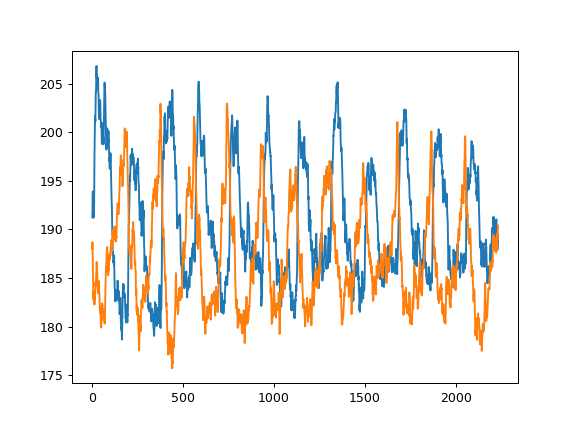

In [50]:
pl.figure()
pl.plot(traces['right'][175])
pl.plot(traces['left'][175])

# Do fft

In [51]:
fft_data = dict((cond, do_fft_analysis(tdf, idx, n_frames)) for cond, tdf in traces.items())


In [52]:
magratios = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_data.items()))
phases = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_data.items()))


In [53]:
mean_magratio_values = magratios.mean(axis=1).values

In [54]:
sorted_rois = np.argsort(mean_magratio_values)[::-1]
for roi in sorted_rois[0:20]:
    print(roi, mean_magratio_values[roi])

(437, 0.14183053184662625)
(442, 0.13596600010230495)
(448, 0.13563823814149512)
(43, 0.1345635667364985)
(174, 0.13376195991009363)
(438, 0.13307433773640134)
(51, 0.1325754635975041)
(436, 0.1324012020695361)
(10, 0.13219335427291548)
(440, 0.1321136362368844)
(452, 0.13168215254796456)
(44, 0.1314237232858212)
(450, 0.1313076529463921)
(369, 0.13110158968019728)
(14, 0.13108032259058977)
(33, 0.13069449207881037)
(370, 0.13062266688410792)
(46, 0.13060366828991554)
(86, 0.13050680078709118)
(45, 0.13048298044020165)


In [55]:
mean_magratio_values.min()

0.047800123727046576

In [56]:
np.where(mean_magratio_values>0.1)

(array([  0,   1,   2,   3,   4,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 124, 125, 126, 128, 154, 160, 161, 162, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 183, 184, 185,
        186, 187, 188, 189, 197, 198, 211, 212, 213, 214, 215, 216, 218,
        219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
        232, 233, 234, 235, 236, 237, 238, 239, 240

In [57]:
dff_traces = dict((cond, (tdf - tdf.mean(axis=0))/ tdf.mean(axis=0)) for cond, tdf in traces.items())

<IPython.core.display.Javascript object>


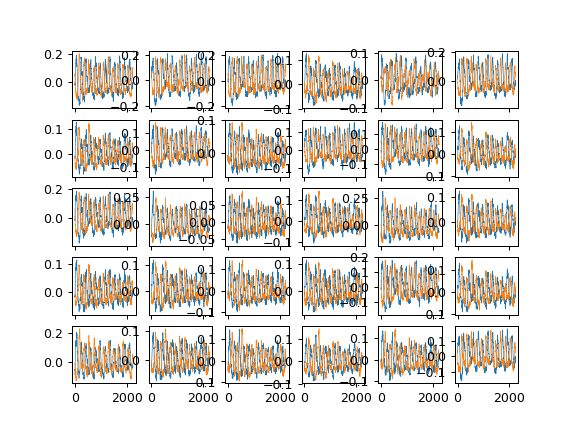

In [58]:
nrois_plot = 30
nr = 5
nc = 6

fig, axes = pl.subplots(nr, nc, sharex=True, sharey=False)
for ax, roi in zip(axes.flat, sorted_rois[0:nrois_plot]):
    ax.plot(dff_traces['right'][roi], lw=0.5)
    ax.plot(dff_traces['left'][roi], lw=0.5)

# Compare magratio to df/f

<IPython.core.display.Javascript object>


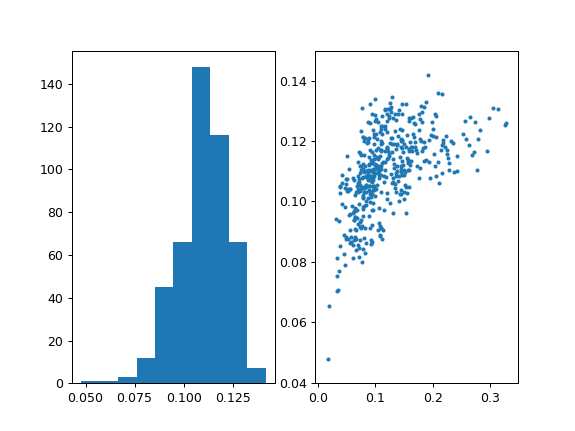

In [59]:
fig, axes = pl.subplots(1,2) #.figure()
axes[0].hist(mean_magratio_values)
axes[1].scatter(dff_traces[currcond].max(axis=0), mean_magratio_values, s=5)

# Plot roi maps

In [60]:
# def mask_rois(masks, value_array, mask_thr=0.1. average_overlap=False):
#     nrois, d1, d2 = masks.shape
#     dims = (d1, d2)

#     if average_overlap:
#         value_mask = np.empty(masks.shape)
#         for rid in value_array.index.tolist():
#             value_mask[rid, masks[rid,:,:]>=mask_thr] = value_array[rid]

#     else:
#         value_mask =  np.ones(dims)*-100
#         for rid in value_array.index.tolist():
#             value_mask[masks[rid,:,:]>=mask_thr] = value_array[rid]

#     return value_mask


def plot_overlaid_maps(curr_cond, phases, magratios, mag_thr=0.03, mask_thr=0.1):

    phase_array = phases[curr_cond]
    magratio_array = magratios[curr_cond]

    phase_array_cont =  -1 * phase_array
    phase_array_cont = phase_array_cont % (2*np.pi)

    phase_mask_tmp = mask_rois(masks, phase_array_cont, mask_thr=mask_thr)
    magratio_mask_tmp = mask_rois(masks, magratio_array, mask_thr=mask_thr)
    
    phase_mask = np.ma.masked_where(magratio_mask_tmp==-100, phase_mask_tmp)
    magratio_mask = np.ma.masked_where(magratio_mask_tmp==-100, magratio_mask_tmp)
    
    #magratio_mask_thr = np.copy(magratio_mask)
    #magratio_mask_thr[magratio_mask<mag_thr] = np.nan
    magratio_mask_thr = np.ma.masked_where(magratio_mask<mag_thr, magratio_mask)
    print("max magratio:", magratio_array.max())

    #phase_mask_thr = np.copy(phase_mask)
    #phase_mask_thr[magratio_mask<mag_thr] = np.nan
    phase_mask_thr = np.ma.masked_where(magratio_mask<mag_thr, phase_mask)
    print("max phase:", phase_mask_thr.max())


    fig, axes = pl.subplots(1,3, figsize=(12,5))
    ax = axes[0]
    im = ax.imshow(cnm.estimates.Cn, cmap='gray'); ax.axis('off');
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    ax.figure.colorbar(im, cax=cax, orientation='horizontal')

    ax = axes[1]
    axes[1].imshow(Av, cmap='gray'); ax.axis('off');
    im = ax.imshow(magratio_mask_thr, cmap='inferno', alpha=0.7)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    ax.figure.colorbar(im, cax=cax, orientation='horizontal')

    ax = axes[2]
    axes[2].imshow(Av, cmap='gray'); ax.axis('off');
    im = ax.imshow(phase_mask_thr, cmap='nipy_spectral', vmin=0, vmax=2*np.pi, alpha=0.7); ax.axis('off');
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.1)
    ax.figure.colorbar(im, cax=cax, orientation='horizontal')

    pl.subplots_adjust(wspace=0.5, hspace=0.5)

    return fig


In [61]:
def dilate_mask_centers(maskcenters, kernel_size=9):
#     a = np.zeros((5, 5))
#     struct1 = ndimage.generate_binary_structure(2, 1)
    
#     kernel = ndimage.binary_dilation(a, structure=struct1, iterations=sigma).astype(a.dtype)
    
    kernel_radius = (kernel_size - 1) // 2
    x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
    dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

    # let's create three kernels for the sake of example
    radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
    # using ... allows compatibility with arbitrarily-shaped radius arrays

    kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)

    dilated_masks = np.zeros(maskcenters.shape, dtype=maskcenters.dtype)
    for roi in range(maskcenters.shape[0]):
        img = maskcenters[roi, :, :].copy()
        x, y = np.where(img>0)
        centroid = (sum(x) / len(x), sum(y) / len(x))
        #print(centroid)
        np_tmp = np.zeros(img.shape, dtype=bool)
        np_tmp[centroid] = True
        dilation = binary_dilation(np_tmp, structure=kernel )
        dilated_masks[roi, : :] = dilation
    return dilated_masks

In [62]:
import scipy.stats as spstats
def mask_rois(masks, value_array, mask_thr=0.1, return_array=False):
    nrois, d1, d2 = masks.shape
    dims = (d1, d2)

    if return_array:
        value_mask = np.ones(masks.shape)*np.nan #-100
        for rid in value_array.index.tolist():
            value_mask[rid, masks[rid,:,:]>=mask_thr] = value_array[rid]

    else:
        value_mask =  np.ones(dims)*-100
        for rid in value_array.index.tolist():
            value_mask[masks[rid,:,:]>=mask_thr] = value_array[rid]

    return value_mask



In [63]:
def mask_with_overlaps_averaged(dilated_masks, value_array, mask_thr=0.1):
    nrois, d1, d2 = dilated_masks.shape
    
    # Get non-averaged array
    tmpmask = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=False)
    
    # Get full array to average across overlapping pixels
    tmpmask_full = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=True)
    tmpmask_r = np.reshape(tmpmask_full, (nrois_total, d1*d2))
    
    # Replace overlapping pixels with average value
    avg_mask = tmpmask.copy().ravel()
    multi_ixs = [i for i in range(tmpmask_r.shape[-1]) if len(np.where(tmpmask_r[:, i])[0]) > 1]
    for ix in multi_ixs:
        #avg_azim[ix] = spstats.circmean([v for v in azim_phase2[:, ix] if not np.isnan(v)], low=vmin, high=vmax)
        avg_mask[ix] = np.nanmean([v for v in tmpmask_r[:, ix] if not np.isnan(v)])#, low=vmin, high=vmax)

    avg_mask = np.reshape(avg_mask, (d1, d2))

    return avg_mask

# Filter cells

In [64]:
mag_thr=0.01 if trace_type == 'neuropil' else 0.01
all_conds_pass = True
if all_conds_pass:
    roi_list = [i for i in magratios.index if all(magratios.loc[i] >= mag_thr)]
    
print("%i out of %i cells pass mag-ratio thr (thr>=%.2f)" % (len(roi_list), len(mean_magratio_values), mag_thr))

465 out of 465 cells pass mag-ratio thr (thr>=0.01)


# Get mask info

In [65]:
# Get masks
mcenters=None
maskcenters = None
rid_fpath = glob.glob(os.path.join(rootdir, animalid, session, 'ROIs', 'rids*.json'))[0]
with open(rid_fpath, 'r') as f:
    rids = json.load(f)
reffile = rids[roiid]['PARAMS']['options']['ref_file']

if trace_type == 'neuropil':
    tmpm = tfile['File%03d' % int(reffile)]['np_masks'][:].T
    mcenters = tfile['File%03d' % int(reffile)]['masks'][:].copy()
else:
    tmpm = tfile['File%03d' % int(reffile)]['masks'][:].copy()


nrois_total, _ = tmpm.shape
masks = np.reshape(tmpm, (nrois_total, d1, d2))
masks[masks>0] = 1
if trace_type=='neuropil':
    maskcenters = np.reshape(mcenters, (nrois_total, d1, d2))
    maskcenters[maskcenters>0] = 1
print(masks.shape)

(465, 256, 512)


In [66]:
print( tfile['File%03d' % int(reffile)].keys())

[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']


In [67]:
masks.shape

(465, 256, 512)

In [68]:
zimg.shape

(256, 512)

In [69]:
d1

256

<IPython.core.display.Javascript object>


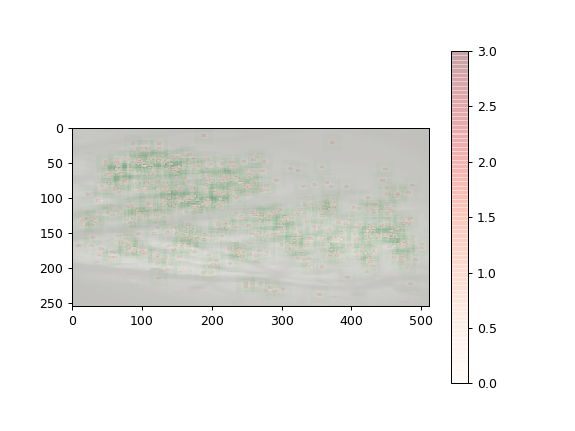

In [70]:
pl.figure()
pl.imshow(zimg, cmap='gray', alpha=0.5)
pl.imshow(masks.sum(axis=0), cmap='Greens', alpha=0.4)
if trace_type == 'neuropil':
    pl.imshow(maskcenters.sum(axis=0), cmap='Reds', alpha=0.2)
pl.colorbar()

# Get center of contours (neuropil)

In [71]:
import cv2
import imutils

In [72]:
from scipy.ndimage.morphology import binary_dilation
from scipy import ndimage

In [73]:
31/3.

10.333333333333334

(21, 21)


<IPython.core.display.Javascript object>


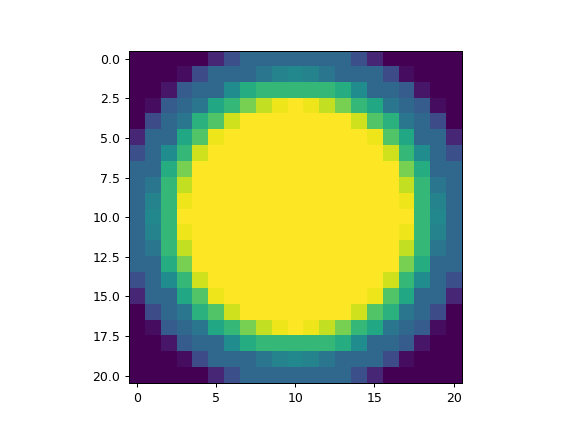

In [96]:
# a = np.zeros((sigma, sigma))
# a[int(np.floor(sigma/2.)), int(np.floor(sigma/2.))] = 1
# struct1 = ndimage.generate_binary_structure(2, 1)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

#kernel = ndimage.binary_dilation(a, structure=struct1, iterations=sigma/2)

kernel_size = 21
kernel_radius = (kernel_size - 1) // 2
x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

# let's create three kernels for the sake of example
radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
# using ... allows compatibility with arbitrarily-shaped radius arrays

kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)
print(kernel.shape)
pl.figure()
pl.imshow(kernel)

In [147]:
len(roi_list)

443

<IPython.core.display.Javascript object>


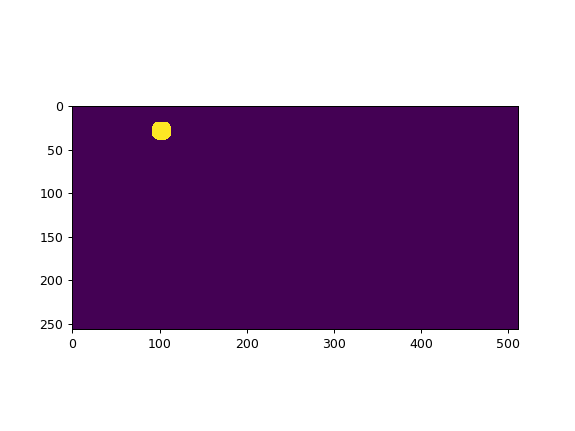

20
20


In [97]:
if trace_type == 'neuropil':
    dilated_masks = dilate_mask_centers(maskcenters, kernel_size=21)

    pl.figure()
    pl.imshow(dilated_masks[0, :, :])

    x, y = np.where(dilated_masks[0, :, :]>0)
    print x.max()-x.min()
    print y.max()-y.min()
else:
    dilated_masks =  masks.copy() #dilate_mask_centers(masks, kernel_size=5)

<IPython.core.display.Javascript object>


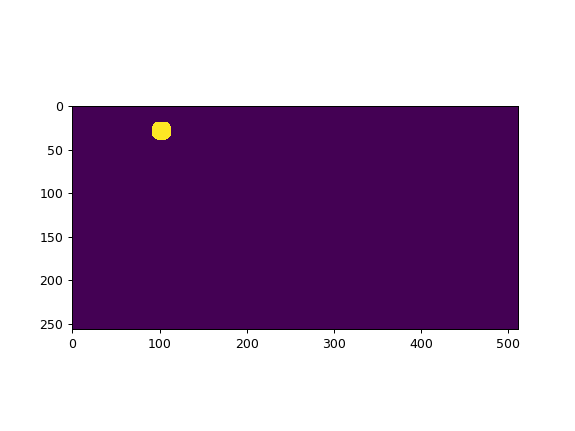

In [98]:
pl.figure()
pl.imshow(dilated_masks[0, :, :])

<IPython.core.display.Javascript object>


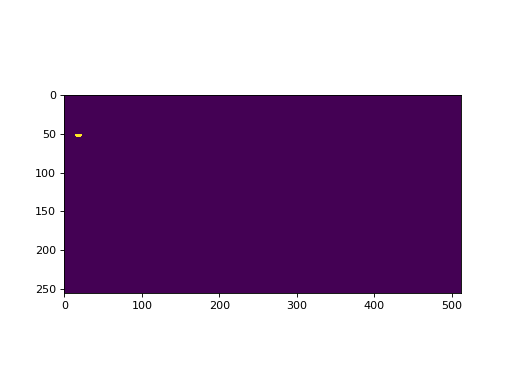

In [691]:
pl.figure()
pl.imshow(masks[0, :, :])

In [77]:
len(roi_list)

465

# Get phase masks

In [78]:

phases_cont = -1 * phases
phases_cont = phases_cont % (2*np.pi)

In [79]:
use_cont = True
filter_by_mag = True
mask_thr=0.01

if use_cont:
    elev = (phases_cont['bottom'] - phases_cont['top']) / 2.
    azim = (phases_cont['left'] - phases_cont['right']) / 2.

    vmin = -np.pi
    vmax = np.pi
    
else:
    elev = (phases['bottom'] - phases['top']) / 2.
    azim = (phases['left'] - phases['right']) / 2.

    elev_c = -1 * elev
    elev_c = elev_c % (2*np.pi)

    azim_c = -1 * azim
    azim_c = azim_c % (2*np.pi)

    vmin = 0
    vmax = 2*np.pi
    
    azim = copy.copy(azim_c)
    elev = copy.copy(elev_c)

#magratios_all = magratios.mean(axis=1)
    
if filter_by_mag:
    if trace_type == 'neuropil':
        print("... using np centers")
        azim_phase = mask_with_overlaps_averaged(dilated_masks, azim[roi_list], mask_thr=mask_thr)
        elev_phase = mask_with_overlaps_averaged(dilated_masks, elev[roi_list], mask_thr=mask_thr)
    else:
        azim_phase = mask_rois(dilated_masks, azim[roi_list], mask_thr=mask_thr)
        elev_phase = mask_rois(dilated_masks, elev[roi_list], mask_thr=mask_thr)
else:
    azim_phase = mask_rois(masks, azim, mask_thr=mask_thr)
    elev_phase = mask_rois(masks, elev, mask_thr=mask_thr)

azim_phase_mask = np.ma.masked_where(azim_phase==-100, azim_phase)
elev_phase_mask = np.ma.masked_where(elev_phase==-100, elev_phase)


... using np centers


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


# Test smoothing with nans

<IPython.core.display.Javascript object>


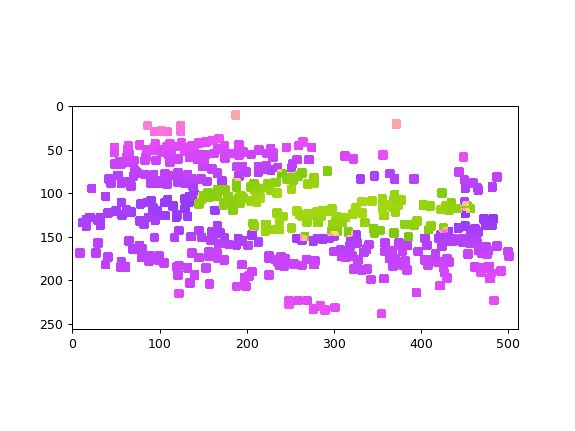

In [80]:
pl.figure()
pl.imshow(azim_phase, cmap=cmap_phase, vmin=vmin, vmax=vmax)

# Check resizing

#### Reshape array, if need

<IPython.core.display.Javascript object>


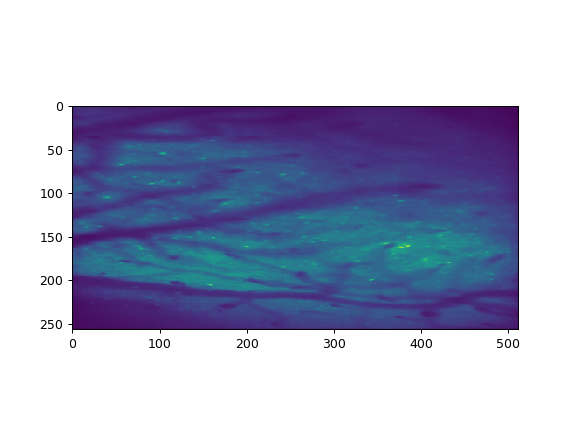

In [85]:
pl.figure()
pl.imshow(zimg)

<IPython.core.display.Javascript object>


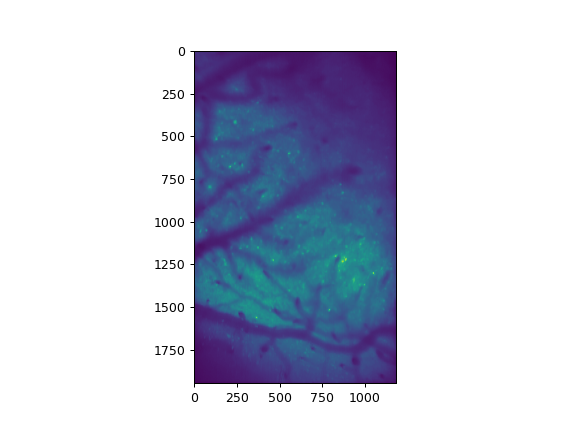

In [86]:
new_d1 = int(round(d1*2.312*2, 1))
new_d2 = int(round(d2*1.904*2, 1))
zimg_r = cv2.resize(zimg, (new_d1, new_d2))
pl.figure()
pl.imshow(zimg_r)

In [82]:
import tifffile as tf

In [87]:
testout = os.path.join(outdir, 'test_resize.tif')
tf.imsave(testout, zimg_r.astype('int16')) #.astype('uint8'))


In [88]:
zimg_r.dtype

dtype('float64')

In [89]:
skey

NameError: name 'skey' is not defined

# Smooth

In [90]:

def smooth_neuropil(azim_r, smooth_fwhm=21):
    V=azim_r.copy()
    V[np.isnan(azim_r)]=0
    VV=ndimage.gaussian_filter(V,sigma=smooth_fwhm)

    W=0*azim_r.copy()+1
    W[np.isnan(azim_r)]=0
    WW=ndimage.gaussian_filter(W,sigma=smooth_fwhm)

    azim_smoothed = VV/WW
    return azim_smoothed


In [91]:
#azim_smoothed = azim_r.copy() #azim_phase.copy()
#azim_smoothed[azim_r==-100] = np.nan

smooth_fwhm = 21
#azim_smoothed = smooth_array(azim_smoothed, smooth_fwhm, phaseArray=True)
azim_smoothed = smooth_neuropil(azim_phase, smooth_fwhm=smooth_fwhm)
elev_smoothed = smooth_neuropil(elev_phase, smooth_fwhm=smooth_fwhm)

In [92]:
if 'zoom1p0x' in fov:
    print("... resizing")
    azim_smoothed = cv2.resize(azim_smoothed, (new_d1, new_d2))
    elev_smoothed = cv2.resize(elev_smoothed, (new_d1, new_d2))
    


... resizing


<IPython.core.display.Javascript object>


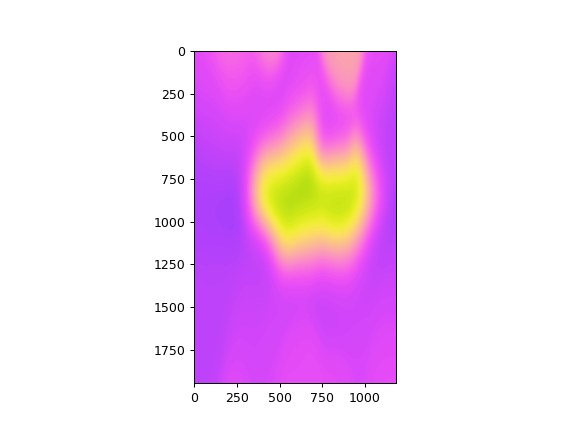

In [93]:
pl.figure()
pl.imshow(azim_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)

In [122]:
masks.min()

0.0

<IPython.core.display.Javascript object>


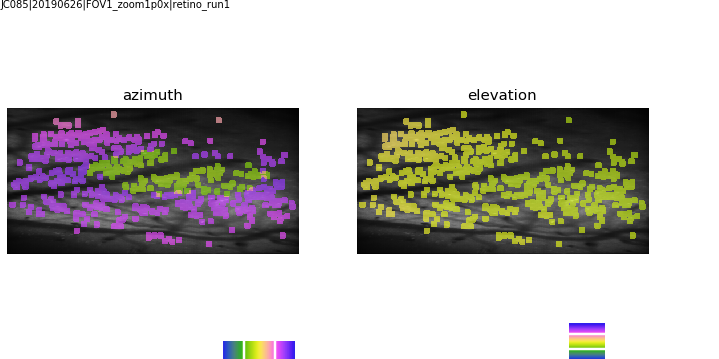

absolute_maps_filter_allconds_magthr_0.01_465cells


In [94]:
label = False
label_str = '_labeled' if label else ''
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin, vmax)
alpha = 0.7
cmap = cmap_phase

fig, axes = pl.subplots(1,2, figsize=(8, 4))
# -- azimuth --
ax = axes[0]
ax.imshow(zimg, cmap='gray'); ax.axis('off');
im1 = ax.imshow(azim_phase_mask, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)
ax.set_title('azimuth')

if label:
    for roi in strong_cells:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')

    
# -- elevation --
ax = axes[1]
ax.imshow(zimg, cmap='gray'); ax.axis('off');
im2 = ax.imshow(elev_phase_mask, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)
ax.set_title('elevation')

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')



# Colorbar axes are from (0, 1) -- need to reset fraction cutoff between 0, 1...
elev_min = elev_cutoff/2.
elev_max = 1- elev_cutoff/2.


cbar1_orientation='horizontal'
cbar1_axes = [0.31, -0.001, 0.1, 0.05]
cbar2_orientation='vertical'
cbar2_axes = [0.79, -0.001, 0.05, 0.1]

cbaxes1 = fig.add_axes(cbar1_axes) 
cb1 = pl.colorbar(im1, cax=cbaxes1, orientation=cbar1_orientation)  
cb1.ax.axis('off')
cb1.outline.set_visible(False)
cb1.ax.axvline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb1.ax.axvline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')

cbaxes2 = fig.add_axes(cbar2_axes) 
cb2 = pl.colorbar(im2, cax=cbaxes2, orientation=cbar2_orientation)
#cb2.ax.set_ylim(-vmax*elev_cutoff, vmax*elev_cutoff)
cb2.ax.axhline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axhline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axis('off')
cb2.outline.set_visible(False)

pl.subplots_adjust(left=0.01, right=0.9)

if filter_by_mag:
    if all_conds_pass:
        figname = 'absolute_maps_filter_allconds_magthr_%.2f_%icells' % (mag_thr, len(roi_list))
    else:
        figname = 'absolute_maps_filter_maxcond_magthr_%.2f_%icells' % (mag_thr, len(roi_list))
else:
    figname = 'absolute_maps_all_cells'

label_figure(fig, data_identifier)
#pl.savefig(os.path.join(output_dir, '%s%s.png' % (figname, label_str)))

print(figname)

# Plot individual

In [95]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/figures/caiman-examples'

In [165]:
skey = '-'.join([animalid, session, fov, retinorun, retinoid])
print skey

JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002


In [166]:
label = False
label_str = '_labeled' if label else ''
norm = mcolors.Normalize(vmin, vmax)
alpha = 0.7
cmap = cmap_phase

plot_transparent = True
plot_smoothed = True
smooth_fwhm = 25

smooth_str = '_smooth-%i' % smooth_fwhm if plot_smoothed else ''
format_str = '_transparent' if plot_transparent else ''


In [167]:
# Create smoothed arrays
azim_smoothed = azim_phase.copy()
azim_smoothed[azim_phase==-100] = np.nan

elev_smoothed = elev_phase.copy()
elev_smoothed[elev_phase==-100] = np.nan

if trace_type == 'neuropil':
    azim_smoothed = smooth_neuropil(azim_smoothed, smooth_fwhm)
    elev_smoothed = smooth_neuropil(elev_smoothed, smooth_fwhm)

    #azim_smoothed = smooth_array(azim_smoothed, smooth_fwhm, phaseArray=True)
    #elev_smoothed = smooth_array(elev_smoothed, smooth_fwhm, phaseArray=True)
    
if 'zoom1p0x' in fov:
    azim_smoothed = cv2.resize(azim_smoothed, (new_d1, new_d2))
    elev_smoothed = cv2.resize(elev_smoothed, (new_d1, new_d2))

<IPython.core.display.Javascript object>


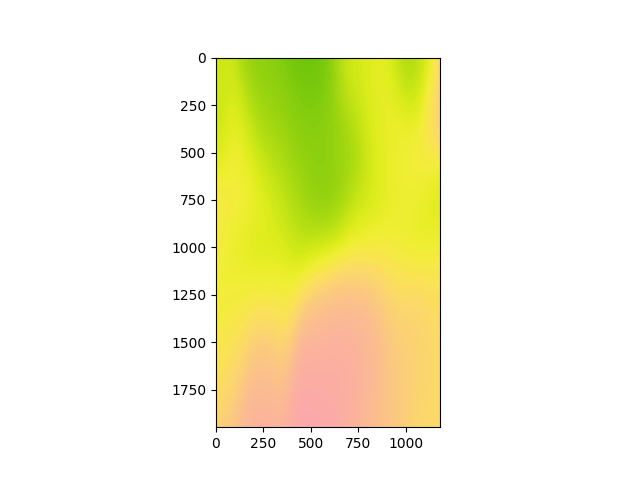

In [168]:
pl.figure()
pl.imshow(elev_smoothed, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)

<IPython.core.display.Javascript object>


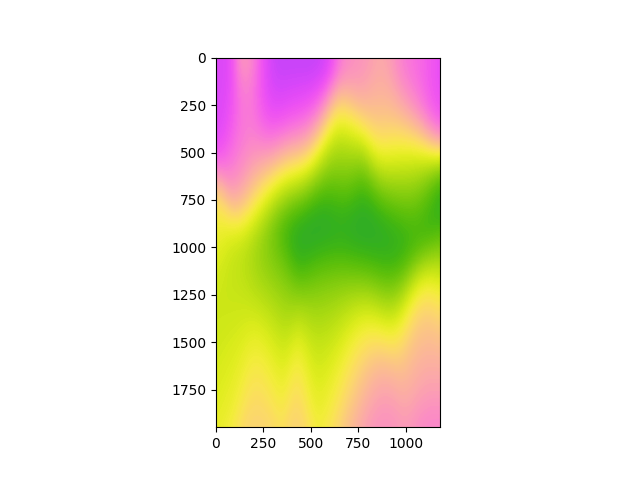

In [169]:
pl.figure()
pl.imshow(azim_smoothed, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)

In [170]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/figures/caiman-examples'

In [171]:
def plot_phase_map(array, zimg=None, cmap='hsv', vmin=-np.pi, vmax=np.pi, alpha=0.7,
                  plot_transparent=True, plot_smoothed=False, ax=None):
    
    norm = mcolors.Normalize(vmin, vmax)
    
    if ax is None:
        fig, ax = pl.subplots()

    if plot_transparent:
        if zimg is not None:
            ax.imshow(zimg, cmap='gray', alpha=0); ax.axis('off')
        ax.patch.set_visible(0)
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    else:
        ax.patch.set_visible(0)
        if zimg is not None:
            ax.imshow(zimg, cmap='gray'); ax.axis('off');
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    return ax

<IPython.core.display.Javascript object>


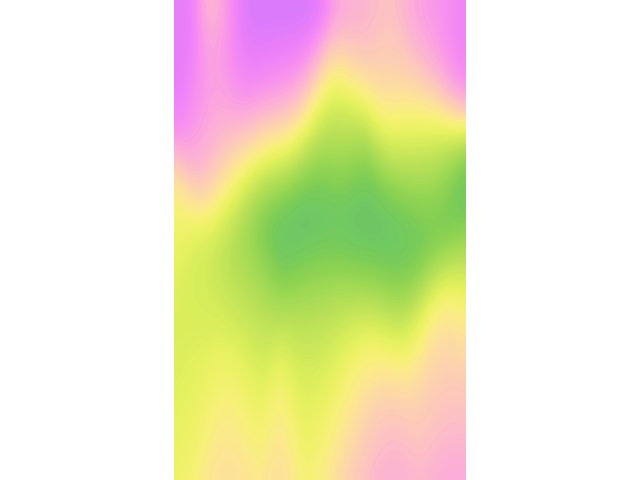

neuropil_absolute-azimuth_filter-allconds-magthr0.01_443cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [172]:

condition = 'azimuth'
if condition == 'azimuth':
    plot_arr = azim_smoothed.copy() if plot_smoothed else azim_phase_mask.copy()
elif condition == 'elevation':
    plot_arr = elev_smoothed.copy() if plot_smoothed else elev_phase_mask.copy()

fig, ax = pl.subplots()
ax = plot_phase_map(plot_arr, zimg=zimg, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha,
                   plot_transparent=plot_transparent, plot_smoothed=plot_smoothed, ax=ax)

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')
    label_figure(fig, data_identifier)

if filter_by_mag:
    figname = '%s_absolute-%s_filter-allconds-magthr%.2f_%icells' % (trace_type, condition, mag_thr, len(roi_list))
else:
    figname = '%s_absolute-%s' % (trace_type, condition)
figname = '%s_%s_%s%s' % (figname, skey, format_str, smooth_str)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)

<IPython.core.display.Javascript object>


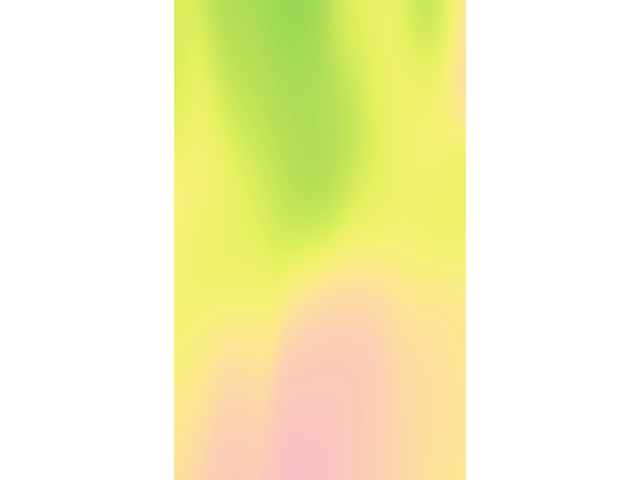

neuropil_absolute-elevation_filter-allconds-magthr0.01_443cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [173]:

condition = 'elevation'
if condition == 'azimuth':
    plot_arr = azim_smoothed.copy() if plot_smoothed else azim_phase_mask.copy()
elif condition == 'elevation':
    plot_arr = elev_smoothed.copy() if plot_smoothed else elev_phase_mask.copy()

fig, ax = pl.subplots()
ax = plot_phase_map(plot_arr, zimg=zimg, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha,
                   plot_transparent=plot_transparent, plot_smoothed=plot_smoothed, ax=ax)

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')
    label_figure(fig, data_identifier)

if filter_by_mag:
    figname = '%s_absolute-%s_filter-allconds-magthr%.2f_%icells' % (trace_type, condition, mag_thr, len(roi_list))
else:
    figname = '%s_absolute-%s' % (trace_type, condition)
figname = '%s_%s_%s%s' % (figname, skey, format_str, smooth_str)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)

# Save legends

<IPython.core.display.Javascript object>


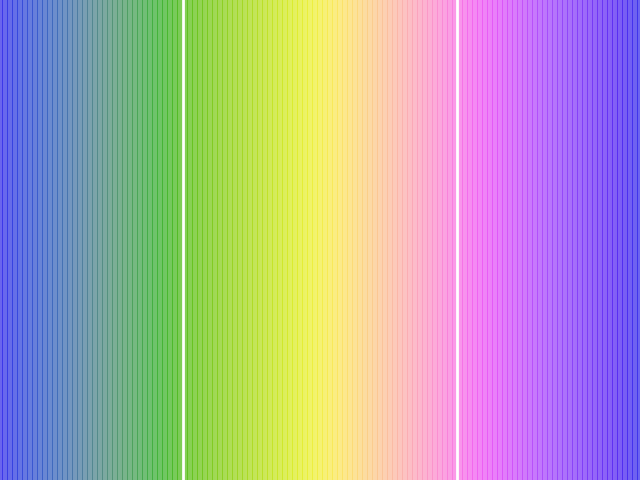

In [117]:
fig = pl.figure()

# Colorbar axes are from (0, 1) -- need to reset fraction cutoff between 0, 1...
elev_min = elev_cutoff/2.
elev_max = 1- elev_cutoff/2.

cbar1_orientation='horizontal'
cbar1_axes = [0, 0, 1, 1] #[0.31, 0.78, 0.1, 0.05]

cbaxes1 = fig.add_axes(cbar1_axes) 
cb1 = pl.colorbar(im1, cax=cbaxes1, orientation=cbar1_orientation)  
cb1.ax.axis('off')
cb1.outline.set_visible(False)
cb1.ax.axvline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb1.ax.axvline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')

pl.savefig(os.path.join(outdir, 'legend_absolute-azimuth.png')) #% (figname, label_str)))


<IPython.core.display.Javascript object>


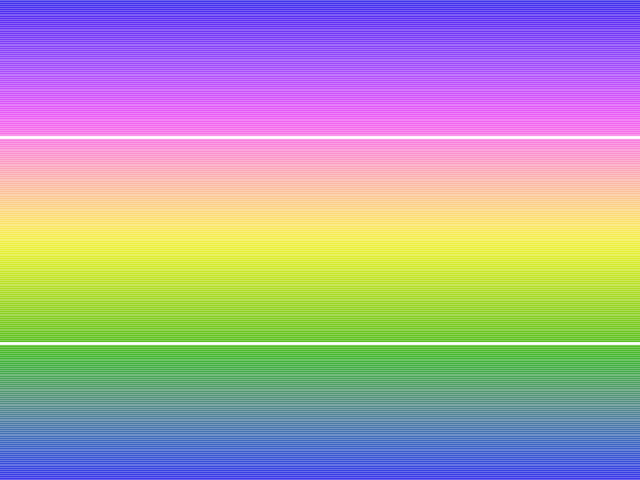

corrected_absolute-elevation_filter-allconds-magthr0.01_174cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [118]:
fig = pl.figure()

cbar2_orientation='vertical'
cbar2_axes = [0, 0, 1, 1] #[0.79, 0.78, 0.1, 0.05]

cbaxes2 = fig.add_axes(cbar2_axes) 
cb2 = pl.colorbar(im2, cax=cbaxes2, orientation=cbar2_orientation)
#cb2.ax.set_ylim(-vmax*elev_cutoff, vmax*elev_cutoff)
cb2.ax.axhline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axhline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axis('off')
cb2.outline.set_visible(False)


#label_figure(fig, data_identifier)
pl.savefig(os.path.join(outdir, 'legend_absolute-elevation.png')) #% (figname, label_str)))

print(figname)